In [13]:
import tensorflow as tf
from tqdm import tqdm
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import re
import numpy as np
import os
import time
import json
from PIL import Image
import pandas as pd
import string

from models import CNN_Encoder, RNN_Decoder, image_features_extract_model

In [9]:
data = pd.read_csv('clean_cpations_n_files.csv')
disney_captions = data.caption.to_list()
disney_images= data.folder.to_list()

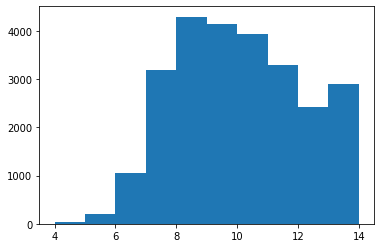

In [10]:
plt.hist([len(t.split(" ")) for t in disney_captions],bins=10);

In [11]:
words = [w.lower() for s in disney_captions for w in s.split(' ')]
print(f' vocab size: {len(set(words))}')
print(f' captions size: {len(disney_captions) }')
print(f' min len for captions {min(len(t.split(" ")) for t in disney_captions)}')
print(f' max len for captions {max(len(t.split(" ")) for t in disney_captions)}')

 vocab size: 14938
 captions size: 25488
 min len for captions 4
 max len for captions 14


In [19]:
# Feel free to change these parameters according to your system's configuration

TOP_K = 14500 # vocab size
BATCH_SIZE = 64
BUFFER_SIZE = 1000  # for shuffle 
embedding_dim = 768 # should not be equal units
units = 512 # gru param
vocab_size = TOP_K + 1
num_steps = len(disney_images) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
# features_shape = 2048
# attention_features_shape = 64

# features_shape_two = 768
# attention_features_two_shape = 17*17

CHECKPOINT_FOLDER = "./checkpoint_dis/augmented_attention"
TOKENIZER_FOLDER = './tokenizer/'

In [17]:
encoder= CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [25]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [26]:
checkpoint_path = CHECKPOINT_FOLDER
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                          optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [21]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=TOP_K,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(disney_captions)

## DISNEY CAPTIONS 
train_seqs = tokenizer.texts_to_sequences(disney_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'


tokenizer_json = tokenizer.to_json()
with open(os.path.join(TOKENIZER_FOLDER,'tokenizer.json'), 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

    
with open(os.path.join(TOKENIZER_FOLDER,'tokenizer.json')) as f:
    data = json.load(f)
    tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
max_sent_len = 16
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_sent_len)
print(f'captions vector shape {cap_vector.shape}')


img_name_train, img_name_val, cap_train, cap_val = train_test_split(disney_images,
                                                                    cap_vector,
                                                                    test_size=0.1,
                                                                    random_state=42)

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

captions vector shape (25488, 16)


(22939, 22939, 2549, 2549)

In [23]:
def load_image_aug(image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (299, 299))
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 10)
        if bool(np.random.randint(2)):
            img = img +  tf.keras.backend.random_normal((299,299,3),0,np.random.randint(20))
        if bool(np.random.randint(2)):
            img = tf.image.random_contrast(img, 0, 2)
        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return img, image_path

In [24]:
# Load the numpy files
def map_func(img_name, cap):
    #img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    img_tensor = load_image_aug(img_name)
    return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(map_func)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [27]:
## LOAD LAST CHECK POINT

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    print(f'load from {ckpt_manager.latest_checkpoint}')
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

load from ./checkpoint_dis/augmented_attention/ckpt-10


In [30]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

@tf.function
def train_step(img_path, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        
        ### CNN Encoder
        batch_features_one, batch_features_two  = image_features_extract_model(img_path)
        # 768               2048
        
        # reshape ex. from  [32, 8, 8, 2048] to [32, 64, 2048]
        batch_features_one = tf.reshape(batch_features_one,
                                    (batch_features_one.shape[0], -1, batch_features_one.shape[3]))  
        
        batch_features_two = tf.reshape(batch_features_two,
                                    (batch_features_two.shape[0], -1, batch_features_two.shape[3]))
        
        features_one, features_two = encoder(batch_features_one, batch_features_two)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features_one, features_two, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss


In [34]:
# SAVE EACH K EPOCHS

K = 5

EPOCHS = 11

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % K == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 11 Batch 0 Loss 0.1192
Epoch 11 Batch 100 Loss 0.0864
Epoch 11 Batch 200 Loss 0.0824
Epoch 11 Batch 300 Loss 0.1079
Epoch 11 Loss 0.094246
Time taken for 1 epoch 107.7023651599884 sec

